# Data visualization
This notebook is for visualizing the data distribution across different demographic groups to get a quick understanding of the sample population and any potential imbalances. 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plot_likert
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from scripts import utils
plot_likert.__internal__.BAR_LABEL_FORMAT = "%.1f" # plotting shows % with 2 decimals

# ignore plotting warnings to save space
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Vars for plotting purposes
courses_cg = ["COMP202", "COMP250", "Other"]
courses_ee = ["COMP251", "COMP424", "COMP551"]
courses = courses_cg + courses_ee

deg_type = ["Undergraduate", "Graduate"]
years = ["U0", "U1", "U2", "U3", "U4+", "M1", "M2", "M3+", "PhD1", "PhD2", "PhD3", "PhD4", "PhD5+"]
majors = ["CS/SWE major", "CS/SWE minor", "Other"]
genders = ["Man", "Woman", "Other", "Prefer not to answer"]
minorities = ["Yes", "No", "Prefer not to answer"]
age = ["<18", "18-24", "25-34", "35-44", ">45", "Prefer not to answer"]
ethics_knowledge = ["Yes", "No"]
likert = range(1, 8)
likert_values = ["Strongly Disagree", "Disagree", "Somewhat Disagree", "Neutral", "Somewhat Agree", "Agree", "Strongly Agree"]

# current semester (for script purposes)
semester = "F2025"

# list of demographic columns
demographics = {"Degree type": deg_type,
                "Year": years,
                "Gender": genders,
                "Visible minority": minorities,
                "Age": age,
                "Ethics experience": ethics_knowledge,
                "Field": majors,
                "Career": likert}

In [34]:
# get all data paths
data_dir = os.path.join(project_root, 'data')

ee_file = f"{semester}_ee_clean.csv"
cg_file = f"{semester}_cg_clean.csv"
questions_file = f"{semester}_survey.yaml"

ee_data_path = os.path.join(data_dir, 'clean', ee_file)
cg_data_path = os.path.join(data_dir, 'clean', cg_file)

In [ ]:
# read CSV data files
ee_data_full = pd.read_csv(ee_data_path, header=[0,1], index_col=0)
cg_data_full = pd.read_csv(cg_data_path, header=[0,1], index_col=0)

# get only the demographic data
ee_data = ee_data_full[list(demographics.keys()) + ["EE course"]]
cg_data = cg_data_full[list(demographics.keys()) + ["CG course"]]

data_all = [ee_data, cg_data]

# rebuild the multiindexing properly to make data access easier
for d in data_all:
    utils.rebuild_multiindex(d)

In [ ]:
# add the students who did not attend EE lecture in the control group
no_ee = ee_data[ee_data["EE course"]["None"] == 1]
ee_data = ee_data[ee_data["EE course"]["None"] == 0]
cg_data = pd.concat([cg_data, no_ee])

cg_data[("CG course", "Other")] = cg_data["EE course"]["None"]
cg_data = cg_data.fillna({"CG course": 0})
cg_data.drop(columns="EE course", level=0, inplace=True)
cg_data = cg_data.sort_index(axis=1)
ee_data = ee_data.sort_index(axis=1)

In [6]:
# get survey questions
with open(os.path.join(data_dir, questions_file), 'r') as yaml_file:
    questions = yaml.safe_load(yaml_file)

Data per course - note that the "Other" category is for students who are part of EE course but did not attend the lecture. 

In [7]:
# create a dataframe for each course
course_data = {}

for course in courses:
    if course in courses_ee:
        course_data[course] = ee_data[ee_data["EE course"][course] == 1]

        # TODO: test this - this is the case where a student is in CG and EE
        '''
        if course in cg_data["EE course"].columns:
            course_data[course] = pd.concat([course_data[course], cg_data[cg_data["EE course"][course] == 1]])
        '''
    else:
        course_data[course] = cg_data[cg_data["CG course"][course] == 1]

## Response number

In [8]:
# number of total responses
n_ee = len(ee_data)
n_cg = len(cg_data)
n_total = n_ee + n_cg

print(f"Number of responses for EE: {n_ee}")
print(f"Number of responses for CG: {n_cg}")

Number of responses for EE: 48
Number of responses for CG: 63


In [9]:
# create the dataframe with the counts and proportions of students for each course
df_dict_n_courses = {"course": [],
                     "count": [],
                     "proportion": [],
                     "group": []}

for course in course_data:
    df_dict_n_courses["course"].append(course)
    df_dict_n_courses["count"].append(len(course_data[course]))
    df_dict_n_courses["proportion"].append(round(100*len(course_data[course])/n_total, 2))
    if course in courses_ee:
        df_dict_n_courses["group"].append("EE group")
    else:
        df_dict_n_courses["group"].append("Control group")

n_courses_df = pd.DataFrame(df_dict_n_courses)

Bar chart is more appropriate here because some students will be in multiple courses. A pie chart is not an accurate representation of the proportions. Note that because of this, the proportions will not necessarily add up to 100%.

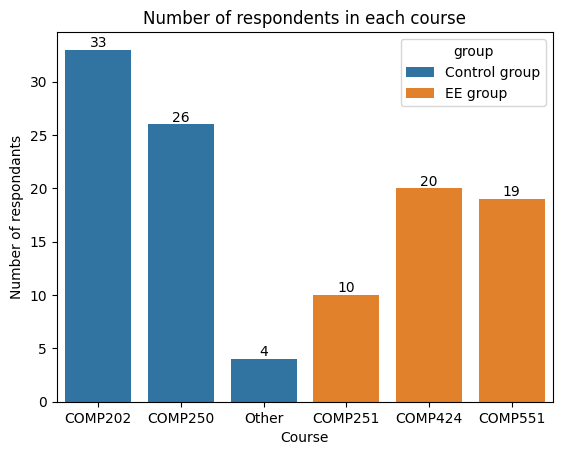

In [10]:
ax = sns.barplot(
    data=n_courses_df,
    x="course",
    y="count",
    hue="group"   # a column indicating skyblue vs darksalmon category
)

ax.set_title("Number of respondents in each course")
ax.set_xlabel("Course")
ax.set_ylabel("Number of respondants")
for container in ax.containers:
    ax.bar_label(container)

Note that this pie chart is not an accurate representation of the group proportions because of students who are enrolled in more than one course. 

Text(0.5, 1.0, 'Number of responses per course')

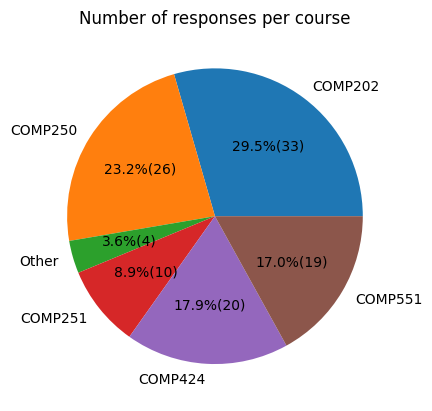

In [11]:
plt.pie(n_courses_df["count"], labels=n_courses_df["course"], autopct=utils.autopct_format(n_courses_df["count"]))
plt.title("Number of responses per course")

## Degree
### EE vs CG

## Demographics: EE vs CG groups
Here, we compare the proportions of answers of each group.

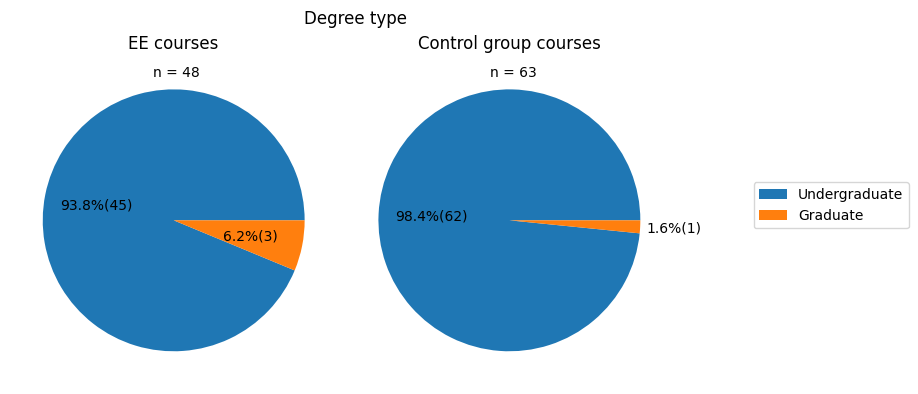

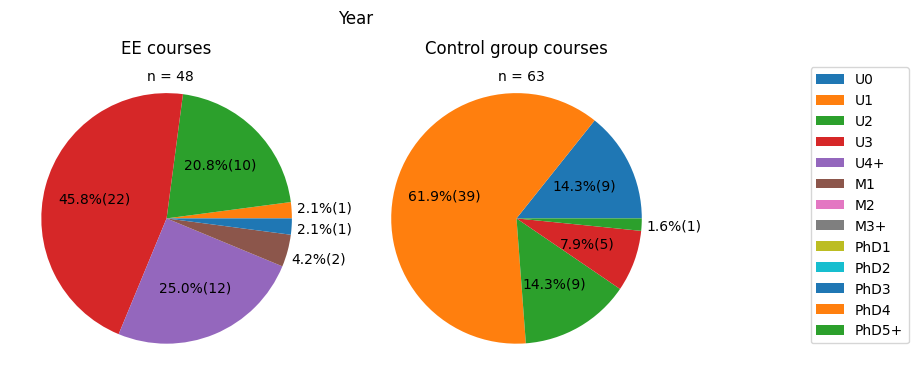

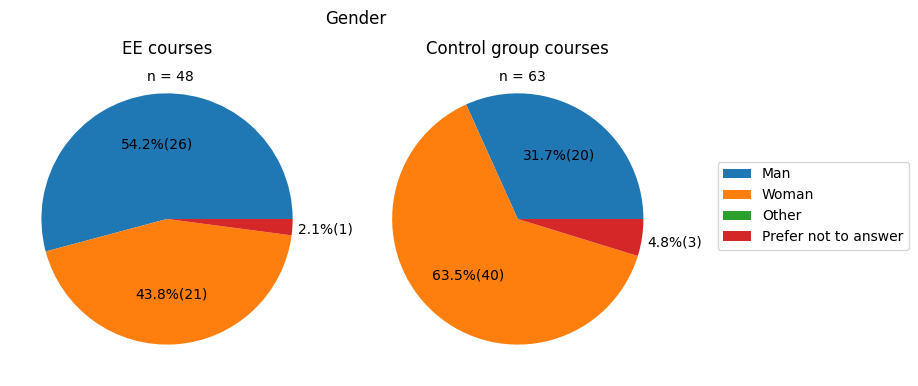

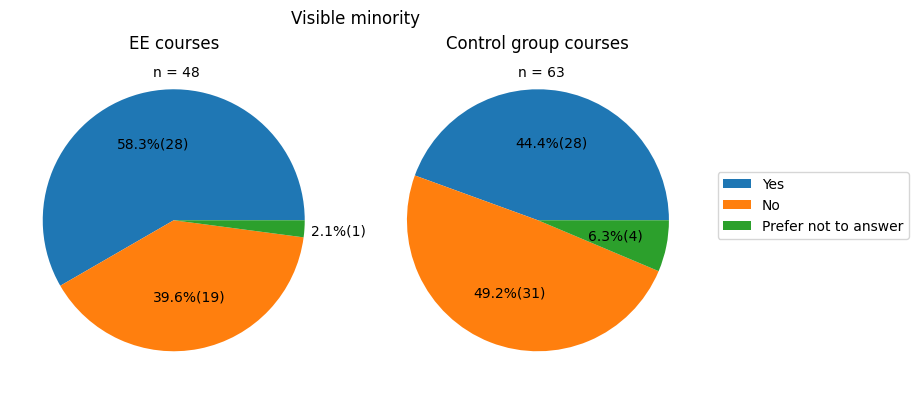

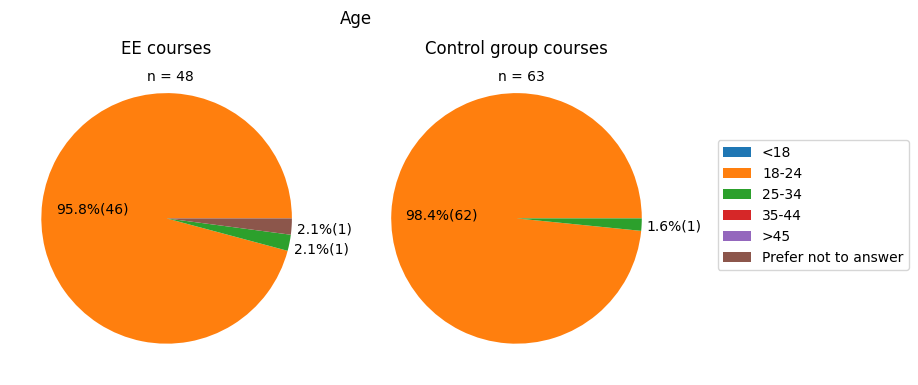

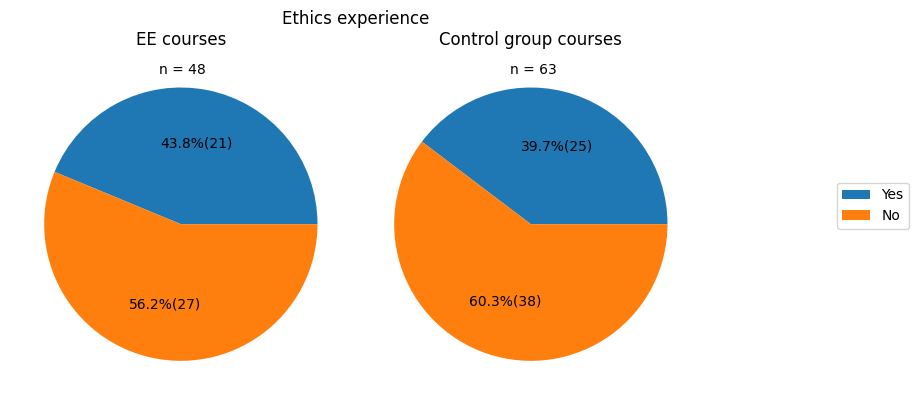

In [12]:
for d in demographics:
    if d != "Field" and d != "Career":
        # get the counts per demographic category for each group
        counts_ee = ee_data[d].value_counts().reindex(demographics[d], fill_value=0) # reindexing adds the categories with 0 count
        counts_cg = cg_data[d].value_counts().reindex(demographics[d], fill_value=0)
        utils.pie_demographics_group(counts_ee, counts_cg, n_ee, n_cg, demographics[d], d)

## Demographic stats per course
Here, we show the proportion of each demographic group per course to see if there are any differences

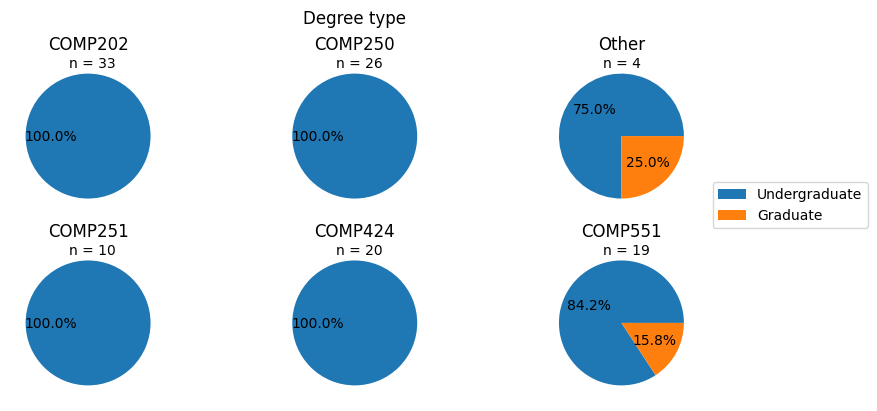

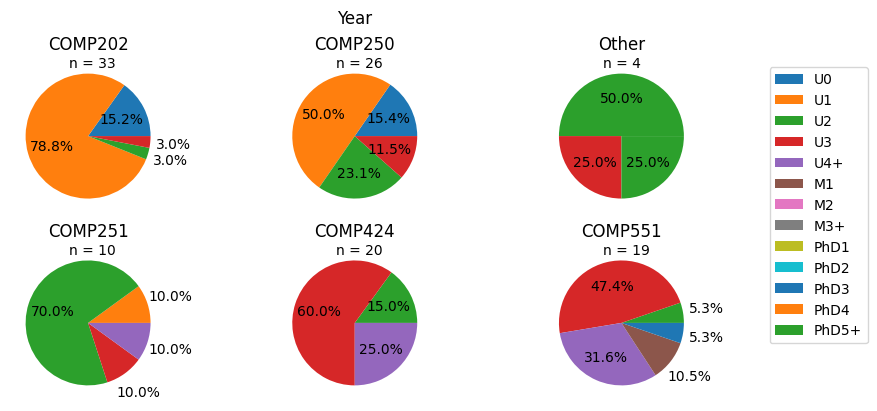

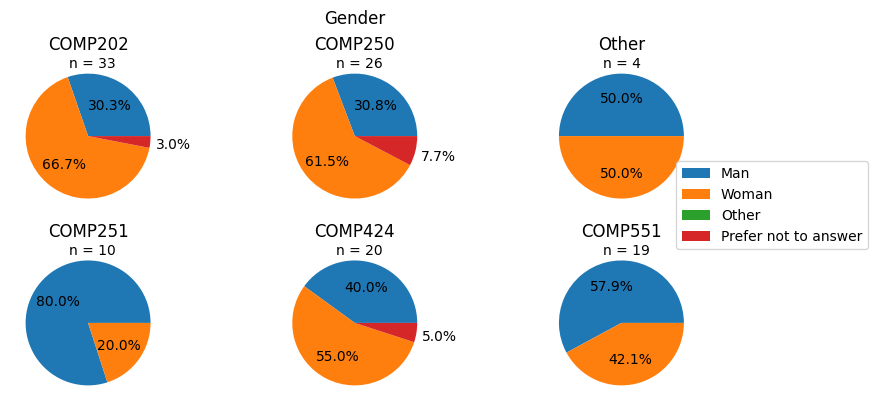

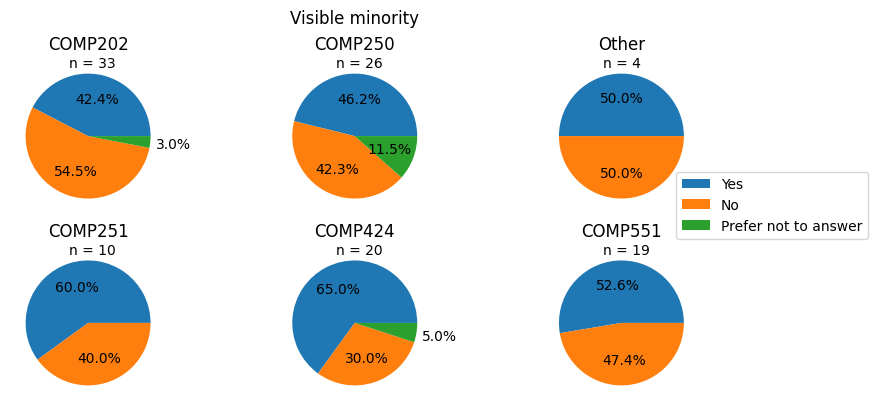

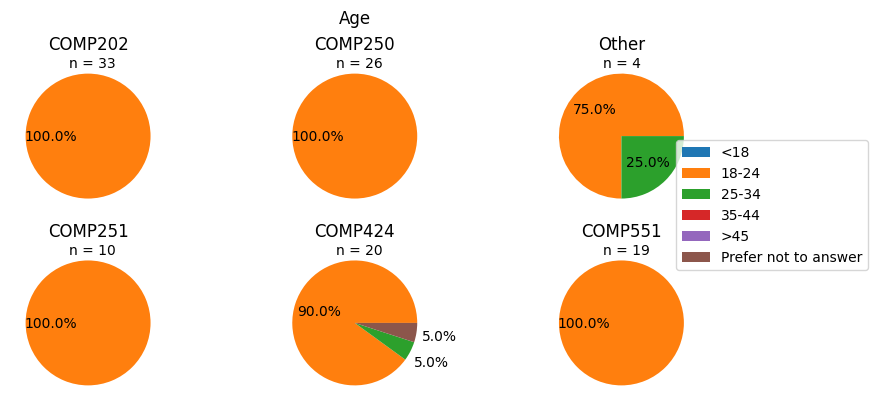

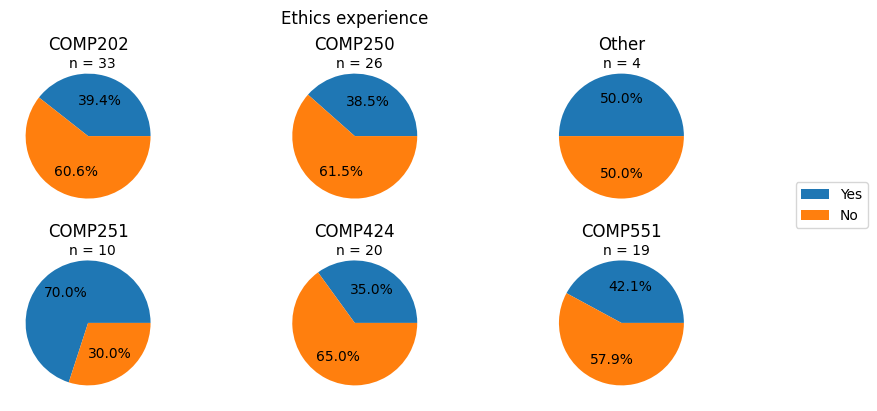

In [14]:
for d in demographics:
    if d != "Field" and d != "Career":
        # get the counts for each course
        counts_courses = {}
        for course in course_data:
            counts_courses[course] = course_data[course][d].value_counts().reindex(demographics[d], fill_value=0)

        # pie chart
        utils.pie_demographics_course(counts_courses, n_courses_df, courses, demographics[d], d)

## Major
Major is plotted as a bar chart since some can be part of multiple groups for majors/minors. Bar charts are therefore more appropriate to show data. 

#### EE vs CG

In [20]:
counts_major_ee_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [ee_data["Field"]["CS/SWE major"].sum(), ee_data["Field"]["CS/SWE minor"].sum(), ee_data["Field"]["Other"].sum()]}
                        
counts_major_cg_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [cg_data["Field"]["CS/SWE major"].sum(), cg_data["Field"]["CS/SWE minor"].sum(), cg_data["Field"]["Other"].sum()]}

counts_major_ee = pd.DataFrame(data=counts_major_ee_dict)
counts_major_cg = pd.DataFrame(data=counts_major_cg_dict)

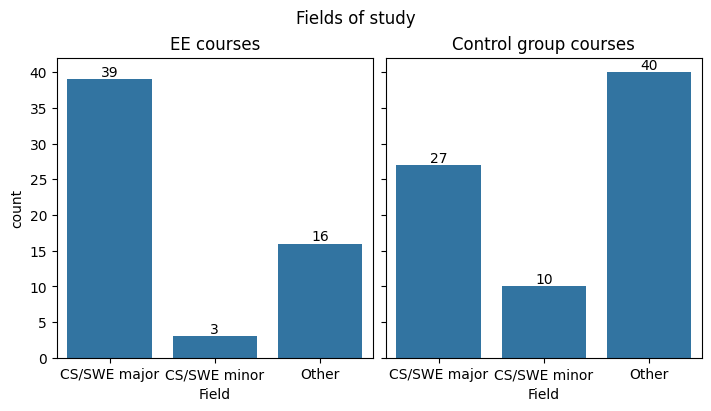

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(7, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.barplot(data=counts_major_ee, x="Field", y="count", ax=ax1)
sns.barplot(data=counts_major_cg, x="Field", y="count", ax=ax2)

fig.suptitle("Fields of study")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

# display counts
for ax in (ax1, ax2):
    for container in ax.containers:
        ax.bar_label(container)

### Major per course

In [23]:
counts_major_course = {}
for course in course_data:
    counts_major_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [course_data[course]["Field"]["CS/SWE major"].sum(), course_data[course]["Field"]["CS/SWE minor"].sum(), course_data[course]["Field"]["Other"].sum()]}
                            
    counts_major_course[course] = pd.DataFrame(data=counts_major_dict)

Text(0.5, 0.98, 'Majors')

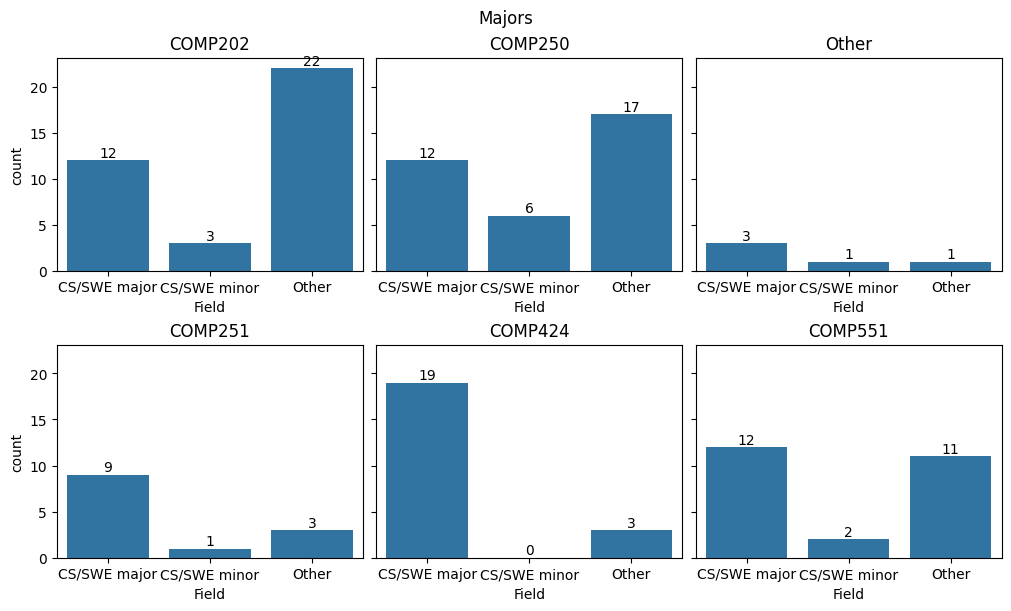

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    sns.barplot(data=counts_major_course[course], x="Field", y="count", ax=axes[row, col])
    axes[row, col].set_title(course)
    for container in  axes[row, col].containers:
         axes[row, col].bar_label(container)

fig.suptitle("Majors")

## Career questions
### EE vs CG

Q1: I plan to pursue a career in computer science or a closely related field (e.g. software engineering)
Q2: Technical and programming skills will be important in my future career
Q3: It is important for me to have a career in which I can make a positive impact on society


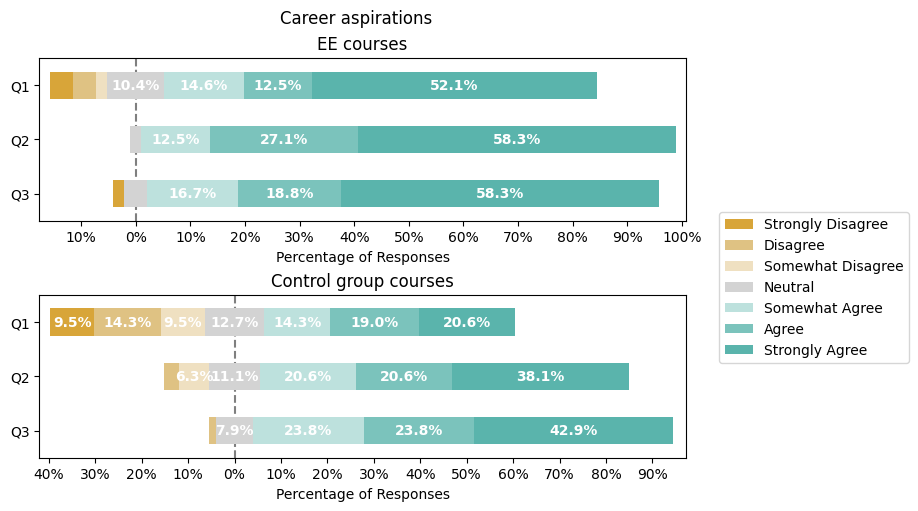

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

plot_likert.plot_likert(ee_data["Career"], likert, plot_percentage=True, colors=plot_likert.colors.likert7, bar_labels=True, ax=ax1, legend=False)
plot_likert.plot_likert(cg_data["Career"], likert, plot_percentage=True, colors=plot_likert.colors.likert7, bar_labels=True, ax=ax2, legend=False)

fig.suptitle("Career aspirations")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, likert_values, bbox_to_anchor=(1.3, 0.6))

for i in range(1, 4):
    print(f"Q{i}: {questions[f"Career Q{i}"]}")

### Career questions per course

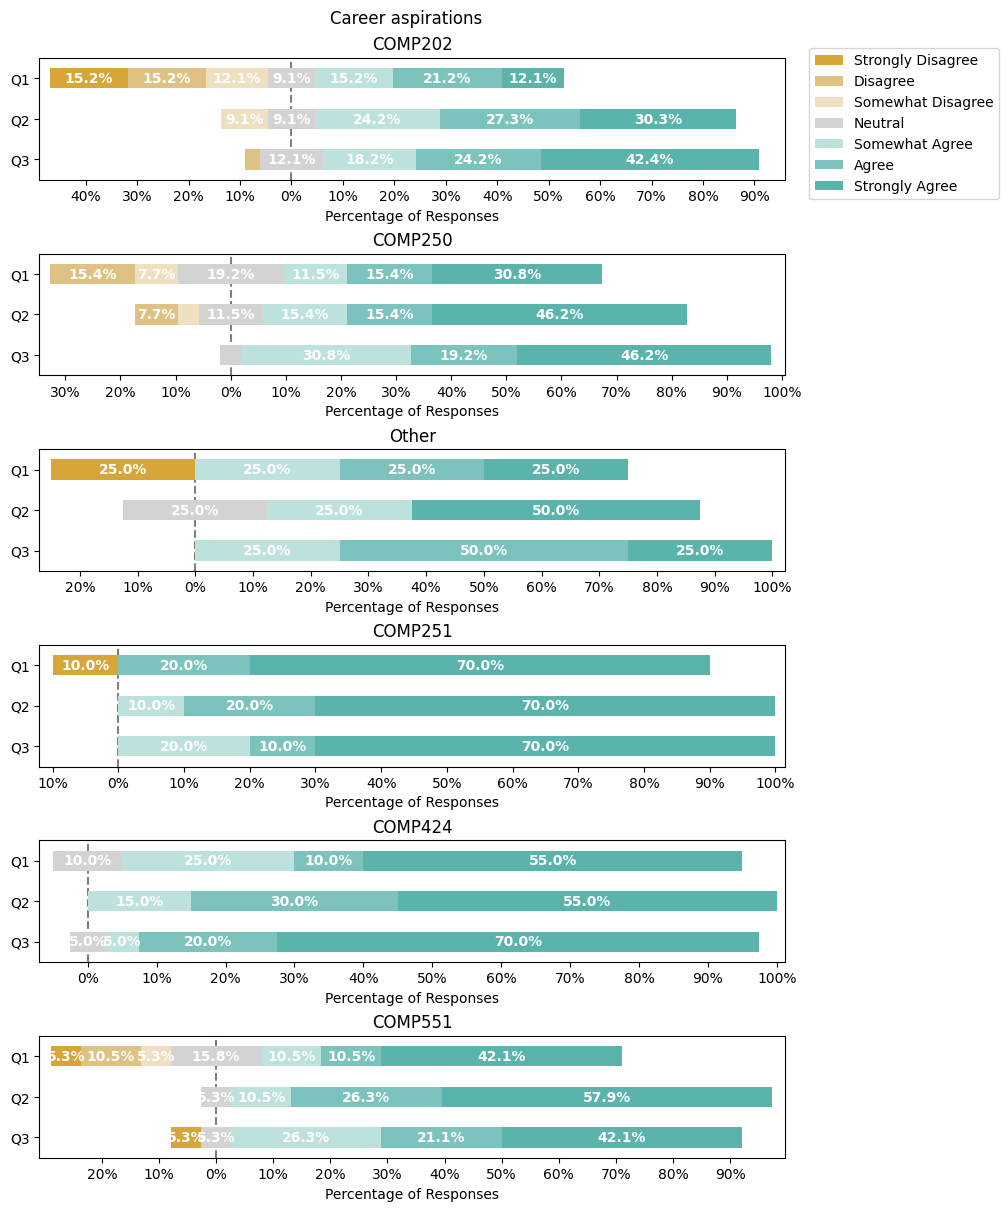

In [33]:
fig, axes = plt.subplots(6, 1, figsize=(8, 12), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    plot_likert.plot_likert(course_data[course]["Career"], likert, plot_percentage=True, colors=plot_likert.colors.likert7, ax=axes[i], bar_labels=True, legend=False)
    axes[i].set_title(course)    

fig.suptitle("Career aspirations")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, likert_values, bbox_to_anchor=(1.25, 0.97))